## Importing Dependencies

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

# from tqdm import tqdm

In [20]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

## CNN Model

In [21]:
class CNN(nn.Module):
  def __init__(self, input_channels,out_channels, kernel_size, stride):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,4,1)
    self.conv2 = nn.Conv2d(6,12,4,1) 
    self.fc1 = nn.Linear(12*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  
  def forward(self, x):
    X = F.relu(self.conv1(x))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    m = nn.Flatten()
    X = m(X)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

## Splitting Data

In [22]:
train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=16, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
#Total number if images in the training set and test set
train_count = len(train_data)
test_count = len(test_data)

print(f"Total number of images in the training set: {train_count}")
print(f"Total number of images in the test set: {test_count}")

Total number of images in the training set: 50000
Total number of images in the test set: 10000


torch.Size([16, 3, 32, 32]) torch.Size([16])


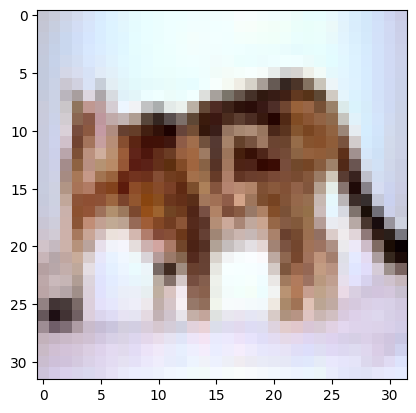

In [24]:
for img, label in train_loader:
  break

print(img.shape, label.shape)

# showing the image  
plt.imshow(img[0].permute(1,2,0))
plt.show()

## Training Model

In [25]:
model = CNN(3,6,4,1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

import time
startTime = time.time()

epochs = 6
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  train_corr = 0
  test_corr = 0
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    train_corr += batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%1000 == 0:
      print(f"Epoch {i} batch {b} loss: {loss.item()}")
  train_losses.append(loss)
  train_correct.append(train_corr)

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1]
      test_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)

total_time = time.time() - startTime
print(f"Total time: {total_time/60} minutes")

Epoch 0 batch 1000 loss: 2.0111517906188965
Epoch 0 batch 2000 loss: 1.4322161674499512
Epoch 0 batch 3000 loss: 1.556396484375
Epoch 1 batch 1000 loss: 1.2888565063476562
Epoch 1 batch 2000 loss: 1.6203542947769165
Epoch 1 batch 3000 loss: 1.2671403884887695
Epoch 2 batch 1000 loss: 1.12142014503479
Epoch 2 batch 2000 loss: 1.1740186214447021
Epoch 2 batch 3000 loss: 1.788752794265747
Epoch 3 batch 1000 loss: 1.3999488353729248
Epoch 3 batch 2000 loss: 1.4128410816192627
Epoch 3 batch 3000 loss: 1.6067214012145996
Epoch 4 batch 1000 loss: 1.4619768857955933
Epoch 4 batch 2000 loss: 0.8830369710922241
Epoch 4 batch 3000 loss: 1.3477318286895752
Epoch 5 batch 1000 loss: 1.1869362592697144
Epoch 5 batch 2000 loss: 1.4333422183990479
Epoch 5 batch 3000 loss: 1.204136610031128
Total time: 3.266421902179718 minutes


## Plotting

In [26]:
type(train_losses[0].cpu().item())

float

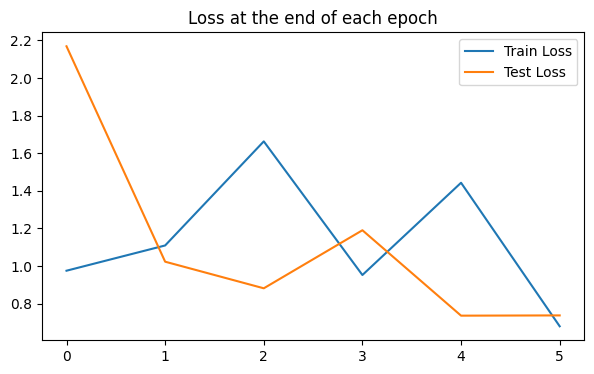

In [35]:
plt.figure(figsize=(7,4))
plt.plot([x.cpu().item() for x in train_losses], label="Train Loss")
plt.plot([x.cpu().item() for x in test_losses], label="Test Loss")
plt.title("Loss at the end of each epoch")
plt.legend()
plt.show()

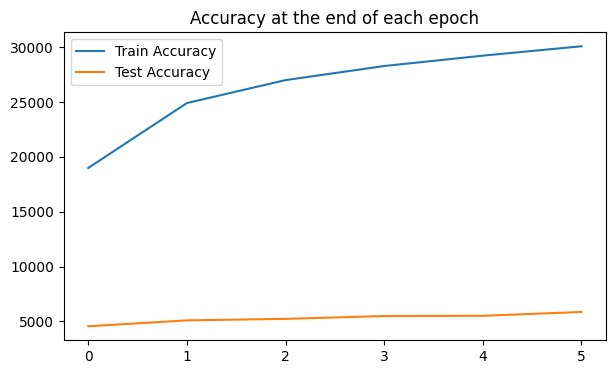

In [37]:
plt.figure(figsize=(7,4))
plt.plot([x.cpu().item() for x in train_correct], label="Train Accuracy")
plt.plot([x.cpu().item() for x in test_correct], label="Test Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()
plt.show()

## Test Accuracy

In [39]:
# print(test_correct) # contains the results of all 6 epochs
# print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') 

Test accuracy: 58.690%
